In [1]:
cd ..

g:\coldfar_py\experiments


In [2]:
cd ..

g:\coldfar_py


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.odr import *
import random
import pylab as pl
from numpy import fft
from datetime import datetime
from pandas_datareader import data as pdr




In [4]:
import numpy as np
import pandas as pd
from numpy_ext import rolling_apply as rolling_apply_ext
import mplfinance as mpf

In [5]:
#https://stackoverflow.com/questions/39492513/scipy-odr-output-intercept-and-slope
# slope is output.beta[0] and the intercept is output.beta[1]


def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [6]:
def get_trend(x, y, if_draw=False):
    # Define a function (quadratic in our case) to fit the data with.
    def linear_func(p, x):
        m, c = p
        return m*x + c
    # Create a model for fitting.
    linear_model = Model(linear_func)
    # Create a RealData object using our initiated data from above.
    data = RealData(x, y)
    # Set up ODR with the model and data.
    odr = ODR(data, linear_model, beta0=[0., 1.])
    # Run the regression.
    out = odr.run()
    if if_draw:
        # Use the in-built pprint method to give us results.
        out.pprint()
        abline(out.beta[0], out.beta[1])
    return out.beta #out.beta[0]是斜率，不受尺寸影響，應該比較有意義

In [7]:
mesdf = pd.read_csv("data\\MES0000_微小SP熱_5分鐘線.csv", index_col = False, encoding = "950", skiprows=1, names = [
    "datetime", "open", "high", "low", "close", "diff", "diff_percentage", "volume", "ma13", "ma34", "ma89", "ma144", "ma233", "+DI7","-DI7","ADX7","to_drop"
])

#mesdf.drop_col(["to_drop"])

mesdf.insert(0, 'symbol', "MES")
mesdf.insert(1, 'contract', "2207")
mesdf.insert(2, 'scale', "5k")

# def dt_to_dtstr_no_symbol(dt):  
#     return dt.strftime('%Y%m%d%H%M%S')

def parse_dt_capital(dtstr):
    return datetime.strptime(dtstr, '%Y/%m/%d %H:%M')

mesdf["datetime"] = mesdf["datetime"].apply(parse_dt_capital) #.apply(dt_to_dtstr_no_symbol)


In [8]:
def stable_arange(start, step, cnt):
    return np.arange(0,cnt)*step+start

In [9]:
mx = mesdf["high"].max()
mn = mesdf["low"].min()
h_delta = (mx - mn)
w_delta = h_delta / 550 * 880
w_unit = w_delta / len(mesdf)
df_ohlc = mesdf[["open", "high", "low", "close"]].copy()
df_ohlc.insert(0, 'id', range(0, len(mesdf)))
df_ohlc["x"] = df_ohlc.apply(lambda r:r.id * w_unit, axis=1)
df_ohlc["o"] = df_ohlc.apply(lambda r:r.open - mn, axis=1)
df_ohlc["h"] = df_ohlc.apply(lambda r:r.high - mn, axis=1)
df_ohlc["l"] = df_ohlc.apply(lambda r:r.low - mn, axis=1)
df_ohlc["c"] = df_ohlc.apply(lambda r:r.close - mn, axis=1)
factor = 1 / w_unit

all_y = df_ohlc["c"].values
all_x = df_ohlc["x"].values
last_x = all_x[-1] + w_unit

all_x_extend_predict = list(stable_arange(last_x, w_unit, 20))
all_x_extend = np.array([*all_x, *all_x_extend_predict])
#extended_None = [np.nan] * n_predict
#all_y_extend = np.array([*all_y, *extended_None])
#全部作為訓練集
fact_all_x_extend = all_x_extend * factor
fact_all_x        = all_x        * factor


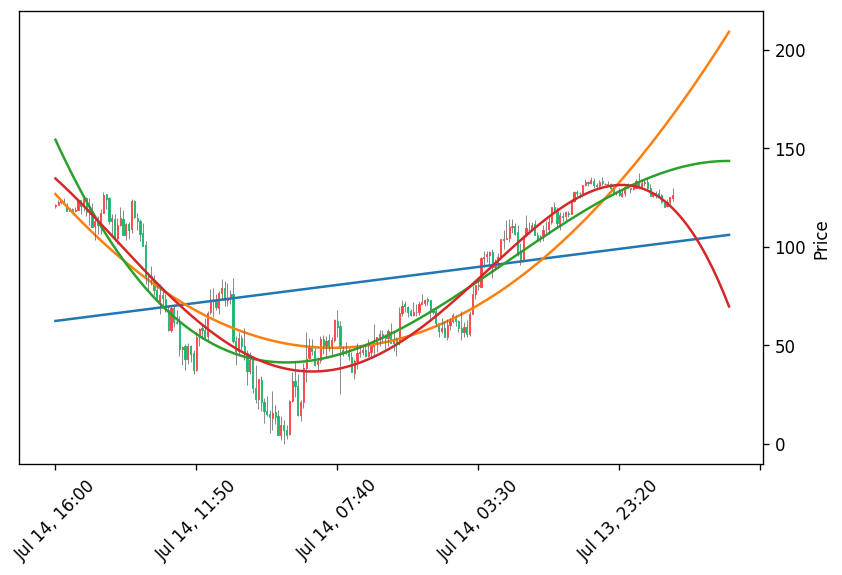

In [10]:
fig, ax1 = pl.subplots(1, figsize=(8, 5), dpi=120, gridspec_kw={'height_ratios': [1]})

def plot_fit(all_x, x, y, ax):

    p1 = np.polyfit(x, y, 1)
    p2 = np.polyfit(x, y, 2)
    p3 = np.polyfit(x, y, 3)
    p4 = np.polyfit(x, y, 4)

    pts1 = np.poly1d(p1)
    pts2 = np.poly1d(p2)
    pts3 = np.poly1d(p3)
    pts4 = np.poly1d(p4)

    fit_y1 = pts1(all_x)
    fit_y2 = pts2(all_x)
    fit_y3 = pts3(all_x)
    fit_y4 = pts4(all_x)
    ax.plot(all_x, fit_y1)
    ax.plot(all_x, fit_y2)
    ax.plot(all_x, fit_y3)
    ax.plot(all_x, fit_y4)

plot_fit(fact_all_x_extend, fact_all_x, all_y * factor, ax1)

xydf_future_df2 = mesdf[["open", "high", "low", "close", "+DI7", "-DI7", "ADX7"]].copy()
xydf_future_df2.columns  = ['Open', 'High', 'Low', 'Close', "+di", "-di", "adx"]
xydf_future_df2["Open"]  = (xydf_future_df2["Open"] - mn) * factor
xydf_future_df2["High"]  = (xydf_future_df2["High"] - mn) * factor
xydf_future_df2["Low"]   = (xydf_future_df2["Low"]  - mn) * factor
xydf_future_df2["Close"] = (xydf_future_df2["Close"]- mn) * factor
xydf_future_df2["dt"] = mesdf["datetime"]
xydf_future_df2 = xydf_future_df2.set_index("dt")

mpf.plot(xydf_future_df2 , type="candle", style='yahoo', ax=ax1)
